In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

# **Question 3**

Is it possible to rank some patterns of land usage with social and environmental factors such as employment, life satisfaction (if data are presents), income inequalities (if data are presents), emissions and finally soil quality and sustainability?

To answer this question we will need to acquire additionnal data, but before doing that, we must define the **scope** of the question. It doesn't really make sense to aggregate countries into continents since the social factors are really specific to each country. Therefore, we reduce our scope to a list of 12 countries that we are interested in and feel are important.

In [2]:
countries = ['France', 'Canada', 'Germany', 'India', 'Japan', 'Russian Federation', 'Switzerland', 'United States of America', 'United Kingdom', 'China', 'Israel']

## Data acquisition and cleaning

In [3]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")
dataLands.head()

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Afghanistan,11,Area,2007.0,1000 Ha,38661.0,Q,agricultural_area
1,Afghanistan,11,Area,2006.0,1000 Ha,38659.0,Fm,agricultural_area
2,Afghanistan,11,Area,2005.0,1000 Ha,38515.0,Fm,agricultural_area
3,Afghanistan,11,Area,2004.0,1000 Ha,38064.0,Fm,agricultural_area
4,Afghanistan,11,Area,2003.0,1000 Ha,38899.0,Fm,agricultural_area


In [4]:
# investigate NaN values
dataLands[np.isnan(dataLands['value'].values)].head(3)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
11154,fnSeqID,Footnote,NaN,NaN,NaN,NaN,NaN,agricultural_area
11155,W,Data reported on country official publications...,NaN,NaN,NaN,NaN,NaN,agricultural_area
11156,E,Expert sources from FAO (including other divis...,NaN,NaN,NaN,NaN,NaN,agricultural_area


We observe that the dataset is pretty clean. The only NaNs in 'value' column are actually the footnotes so we can drop them.

In [5]:
dataLands = dataLands.dropna(subset=["value"])
dataLands.tail(3)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
104773,Zimbabwe,11,Area,1963.0,1000 Ha,23.0,Q,total_area_equipped_for_irrigation
104774,Zimbabwe,11,Area,1962.0,1000 Ha,23.0,Q,total_area_equipped_for_irrigation
104775,Zimbabwe,11,Area,1961.0,1000 Ha,22.0,Q,total_area_equipped_for_irrigation


In [6]:
print(dataLands['category'].unique().tolist())

# we only keep agricultural area
dataLands = dataLands[dataLands['category'] == 'agricultural_area']

['agricultural_area', 'agricultural_area_irrigated', 'arable_land', 'arable_land_and_permanent_crops', 'country_area', 'fallow_land', 'forest_area', 'inland_water', 'land_area', 'other_land', 'perm_crops_irrigated', 'perm_crops_non_irrigated', 'perm_meadows_pastures_cult_irrig', 'perm_meadows_pastures_cult_non_irrig', 'perm_meadows_pastures_cultivated', 'perm_meadows_pastures_nat_grown', 'permanent_crops', 'permanent_meadows_and_pastures', 'temp_crops_irrigated', 'temp_crops_non_irrigated', 'temp_meadows_pastures_irrigated', 'temp_meadows_pastures_non_irrig', 'temporary_crops', 'temporary_meadows_and_pastures', 'total_area_equipped_for_irrigation']


Text(0.5, 1.0, 'Relative evolution of agricultural land area')

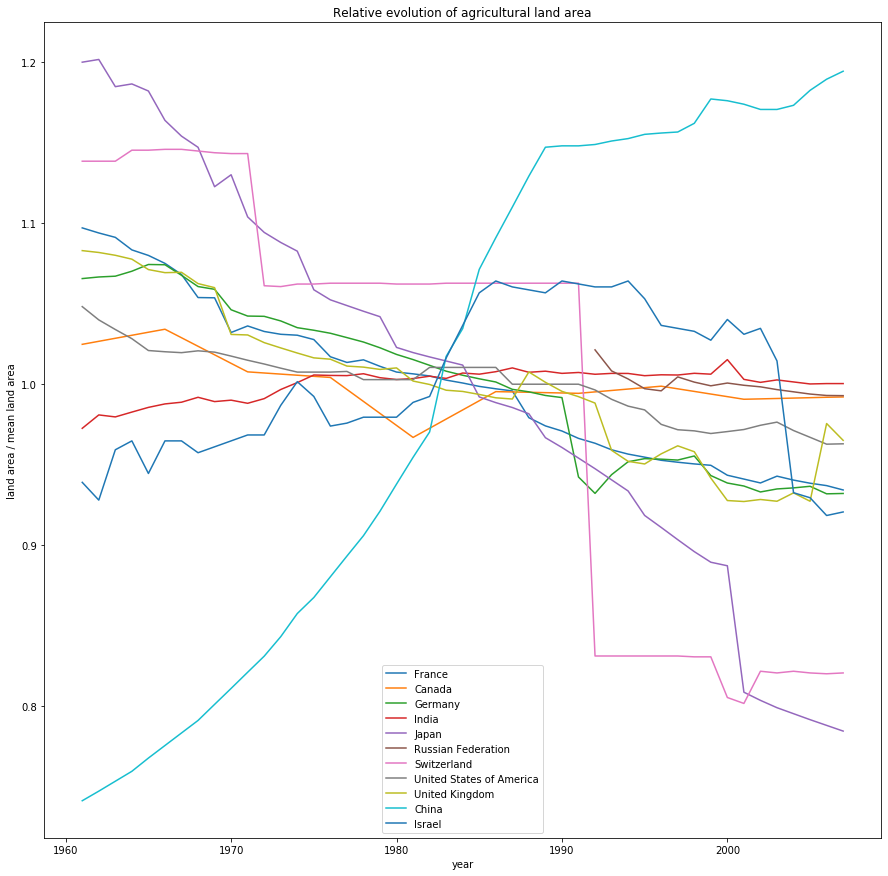

In [7]:
# let's observe the temporal evolution of agricultural lands for our selected countries

def check_country(countries, DF):
    """Checks wether the countries 'countries' are in the dataframe.series DF"""
    for country in countries:
        if country not in DF.unique():
            print('Country', country, 'is missing!')
        
check_country(countries, dataLands['country_or_area'])

# reduce subset to selected countries
rdataLands = dataLands.loc[dataLands['country_or_area'].isin(countries)]

# groupe by country
grdataLands = rdataLands.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # we normalize the total land area by devinding by its mean
    sns.lineplot(x=grdataLands.get_group(country).year, y=grdataLands.get_group(country).value/np.mean(grdataLands.get_group(country).value), label=country)
    
plt.ylabel('land area / mean land area')
plt.title('Relative evolution of agricultural land area')

We observe an overall downward trend the agricultutral land areas except for a few countries (India and China). However, we also notice an anomally with Russia that must be investigated: no data is present before 1991.

After some research we found out that the dissolution of the Soviet Union (USSR) took place on 26 December 1991, creating the country Russia. We must correct our data:

In [8]:
display(dataLands[dataLands['country_or_area'] == 'USSR'].head(3))

# we don't really care about USSR, therefore, we rename it to Russia and subtract (USSR_land_1991 - Russia_land_1992) from its values
to_subtract = dataLands[(dataLands['country_or_area'] == 'USSR') & (dataLands['year'] == 1991)].value.values - dataLands[(dataLands['country_or_area'] == 'Russian Federation') & (dataLands['year'] == 1992)].value.values
# append rdataLands
for year,value in zip(dataLands[dataLands['country_or_area'] == 'USSR'].year.values, dataLands[dataLands['country_or_area'] == 'USSR'].value.values):
    rdataLands = rdataLands.append({'country_or_area':'Russian Federation', 'year':year, 'value':value - to_subtract[0]}, ignore_index=True)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
10512,USSR,11,Area,1991.0,1000 Ha,555420.0,F,agricultural_area
10513,USSR,11,Area,1990.0,1000 Ha,556220.0,I,agricultural_area
10514,USSR,11,Area,1989.0,1000 Ha,556930.0,I,agricultural_area


Text(0.5, 1.0, 'Relative evolution of agricultural land area')

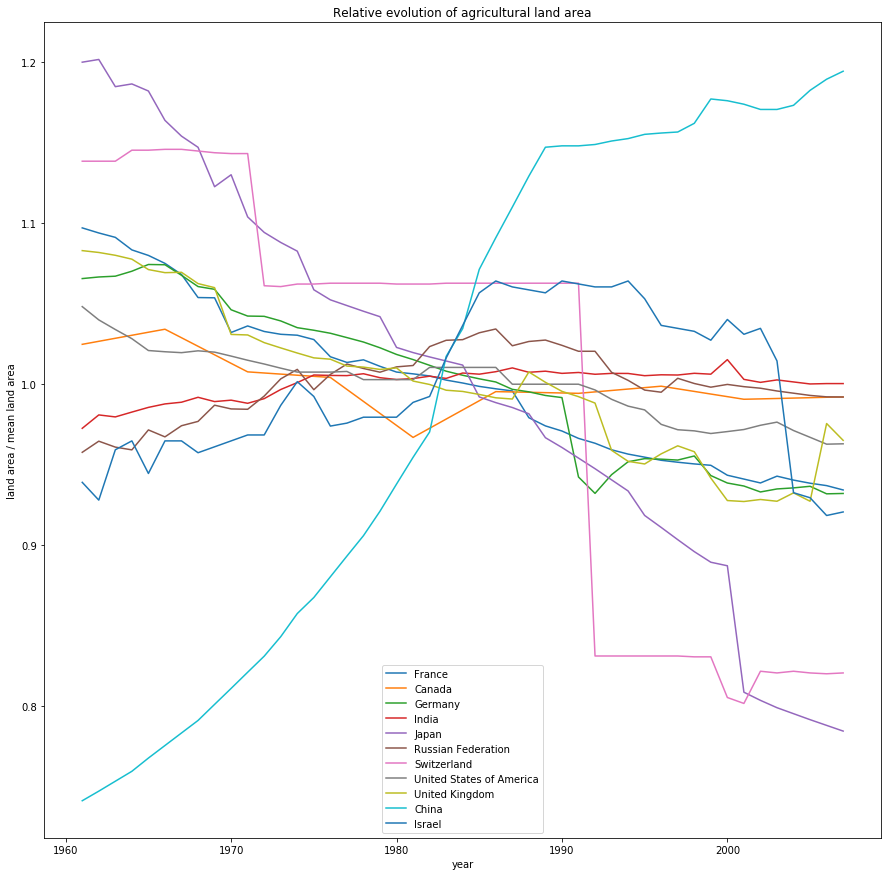

In [9]:
# check the graph again
# groupe by country
grdataLands = rdataLands.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # we normalize the total land area by devinding by its mean
    sns.lineplot(x=grdataLands.get_group(country).year, y=grdataLands.get_group(country).value/np.mean(grdataLands.get_group(country).value), label=country)
    
plt.ylabel('land area / mean land area')
plt.title('Relative evolution of agricultural land area')

## **New Data**
In order to answer the question at the beginning we need some new data:

### Life expectancy at birth for both sexes combined (years):
http://data.un.org/Data.aspx?d=PopDiv&f=variableID%3a68

In [10]:
lifeExp_df = pd.read_csv('data/life_expectancy.csv')
lifeExp_df.head(3)

,Country or Area,Year(s),Variant,Value
0,Afghanistan,2095-2100,Medium,78.25
1,Afghanistan,2090-2095,Medium,77.56
2,Afghanistan,2085-2090,Medium,76.88


In [11]:
# rename columns for consistency
lifeExp_df.rename(columns={'Country or Area': 'country_or_area', 'Year(s)': 'years', 'Variant': 'variant', 'Value': 'value'}, inplace= True)

# Check our list
print(check_country(countries, lifeExp_df['country_or_area']))

# reduce to our selected countries
rlifeExp_df = lifeExp_df.loc[lifeExp_df['country_or_area'].isin(countries)]

# do we have the same problem as before with russia ?
rlifeExp_df[rlifeExp_df['country_or_area']=='Russian Federation'].tail()

None


,country_or_area,years,variant,value
6385,Russian Federation,1970-1975,Medium,68.31
6386,Russian Federation,1965-1970,Medium,68.47
6387,Russian Federation,1960-1965,Medium,67.88
6388,Russian Federation,1955-1960,Medium,64.80
6389,Russian Federation,1950-1955,Medium,58.52


Fortunately we don't have the above problem with Russia in this dataset. We observe that 'Years' is a contains 5 years long periods, thus we transform it and erase the second year (-19**). 

In [12]:
# clean column year
rlifeExp_df['year'] = rlifeExp_df['years'].str.split('-', expand=True).iloc[:,0]
rlifeExp_df.drop(columns='years', inplace= True)
rlifeExp_df

C:\Users\Mathieu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Mathieu\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,country_or_area,variant,value,year
1200,Canada,Medium,91.60,2095
1201,Canada,Medium,91.06,2090
1202,Canada,Medium,90.53,2085
1203,Canada,Medium,90.00,2080
1204,Canada,Medium,89.46,2075
...,...,...,...,...
8155,United States of America,Medium,71.42,1970
8156,United States of America,Medium,70.36,1965
8157,United States of America,Medium,70.11,1960
8158,United States of America,Medium,69.66,1955


### Value added by industries at current prices (ISIC Rev. 3)

We were unable to download all the data from the below website, therefore, we reduced the industries to agriculture.

http://data.un.org/Data.aspx?d=SNA&f=group_code%3a201

In [13]:
valueAdded_df = pd.read_csv('data/value_added.csv', low_memory=False)
valueAdded_df = valueAdded_df.dropna(subset=['Value'])
valueAdded_df.head(3)

,Country or Area,SNA93 Table Code,Sub Group,Item,SNA93 Item Code,Year,Series,Currency,SNA System,Fiscal Year Type,Value,Value Footnotes
0,Afghanistan,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,2018.0,100.0,Afghanis,1993.0,Fiscal year beginning 21 March,3.024495e+11,NaN
1,Afghanistan,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,2017.0,100.0,Afghanis,1993.0,Fiscal year beginning 21 March,3.462690e+11,NaN
2,Afghanistan,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,2016.0,100.0,Afghanis,1993.0,Fiscal year beginning 21 March,3.165100e+11,NaN


In [14]:
# rename columns for consistency
valueAdded_df.rename(columns={'Country or Area': 'country_or_area', 'Year': 'year', 'Value': 'value'}, inplace= True)

# Check our list
print(check_country(countries, valueAdded_df['country_or_area']))

Country United States of America is missing!
None


In [15]:
# print all countries
print(valueAdded_df['country_or_area'].unique().tolist())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'China, Hong Kong Special Administrative Region', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', 'Democratic Republic of the Congo', 'Democratic Yemen [former]', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia [from 1993]', 'Ethiopia [up to 1993]', 'Faro

In [16]:
# Correct for united states
valueAdded_df.replace(to_replace='United States', value='United States of America', inplace= True)

# reduce to our selected countries
rvalueAdded_df = valueAdded_df.loc[valueAdded_df['country_or_area'].isin(countries)]

# do we have the same problem as before with russia ?
rvalueAdded_df[rvalueAdded_df['country_or_area']=='Russian Federation'].tail()

,country_or_area,SNA93 Table Code,Sub Group,Item,SNA93 Item Code,year,Series,Currency,SNA System,Fiscal Year Type,value,Value Footnotes
16080,Russian Federation,2.1,Industries,"Agriculture, hunting, forestry",A,1991.0,100.0,Russian ruble,1993.0,Western calendar year,1.926000e+11,NaN
16081,Russian Federation,2.1,Industries,"Agriculture, hunting and related service activ...",01,1991.0,100.0,Russian ruble,1993.0,Western calendar year,1.911000e+11,NaN
16082,Russian Federation,2.1,Industries,"Agriculture, hunting, forestry; fishing",A+B,1990.0,100.0,Russian ruble,1993.0,Western calendar year,9.960000e+10,NaN
16083,Russian Federation,2.1,Industries,"Agriculture, hunting, forestry",A,1990.0,100.0,Russian ruble,1993.0,Western calendar year,9.960000e+10,NaN
16084,Russian Federation,2.1,Industries,"Agriculture, hunting and related service activ...",01,1990.0,100.0,Russian ruble,1993.0,Western calendar year,9.910000e+10,NaN


Russia's data starts from 1990 so we might have the same problem as before, but USSR is absent from the data...

### Employment by sex and economic activity

https://www.ilo.org/shinyapps/bulkexplorer5/?lang=en&segment=indicator&id=EMP_TEMP_SEX_ECO_NB_A

In [17]:
employment_df = pd.read_csv('data/Employment.csv')
display(employment_df.head(3))
employment_df = employment_df.drop(columns=['obs_status.label', 'note_classif.label', 'note_indicator.label'])   # drop useless columns

,ref_area.label,indicator.label,source.label,sex.label,classif1.label,time,obs_value,obs_status.label,note_classif.label,note_indicator.label,note_source.label
0,Aruba,Employment by sex and economic activity (thous...,ABW - LFS - Labour force survey,Sex: Total,Economic activity (ISIC-Rev.3.1): Total,1994,35.94,NaN,NaN,NaN,Data reference period: October
1,Aruba,Employment by sex and economic activity (thous...,ABW - LFS - Labour force survey,Sex: Total,Economic activity (ISIC-Rev.3.1): A. Agricultu...,1994,0.03,NaN,NaN,NaN,Data reference period: October
2,Aruba,Employment by sex and economic activity (thous...,ABW - LFS - Labour force survey,Sex: Total,Economic activity (ISIC-Rev.3.1): B. Fishing,1994,0.01,NaN,NaN,NaN,Data reference period: October


In [18]:
# rename columns for consistency
employment_df.rename(columns={'ref_area.label': 'country_or_area', 'time': 'year', 'obs_value': 'value', 'classif1.label': 'activity'}, inplace= True)

# Check our list
print(check_country(countries, employment_df['country_or_area']))

# Correct for united states
employment_df.replace(to_replace='United States', value='United States of America', inplace= True)

# reduce to our selected countries
remployment_df = employment_df.loc[employment_df['country_or_area'].isin(countries)]

# USSR isn't present: no problem
np.sort(employment_df['country_or_area'].unique())[-20:]

Country United States of America is missing!
None


array(['Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey',
       'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine',
       'United Arab Emirates', 'United Kingdom',
       'United States of America', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Yemen', 'Zambia',
       'Zimbabwe'], dtype=object)

In [19]:
# do a sub selection of only agricultural related economic activites
remployment_df = remployment_df[remployment_df['activity'].str.contains('Agriculture')]

In [20]:
# extra cleaning
remployment_df.drop(columns=['indicator.label', 'source.label', 'note_source.label'], inplace= True)   # drop useless columns
remployment_df.replace({'Sex: Male': 'male', 'Sex: Female': 'female', 'Sex: Total': 'total'}, inplace= True)

In [21]:
remployment_df.head()

,country_or_area,sex.label,activity,year,value
48061,Canada,total,Economic activity (ISIC-Rev.2): 1. Agriculture...,1969,616.0
48071,Canada,male,Economic activity (ISIC-Rev.2): 1. Agriculture...,1969,543.0
48081,Canada,female,Economic activity (ISIC-Rev.2): 1. Agriculture...,1969,73.0
48091,Canada,total,Economic activity (Aggregate): Agriculture,1969,616.0
48098,Canada,male,Economic activity (Aggregate): Agriculture,1969,543.0


### Non fatal occupational injuries per 100'000 workers by economic activity

We found it hard to find reliable data for the 'quality of life' which could be subjective and not necessarily related to agriculture. Thus, we found the below dataset which describes the amount of non fatal injuries per economic activity, which we found interessting as a way to asses the social quality and safety of agriculture.

https://www.ilo.org/shinyapps/bulkexplorer32/?lang=en&segment=indicator&id=INJ_NFTL_ECO_RT_A

In [22]:
nonFatalInjuries_df = pd.read_csv('data/non_fatal_injuries.csv')

#look at some useless columns before droping them
print(nonFatalInjuries_df.obs_status.unique())
print(nonFatalInjuries_df.note_classif.unique().tolist())
nonFatalInjuries_df = nonFatalInjuries_df.drop(columns=['obs_status', 'obs_status.label', 'note_classif', 'note_classif.label', 'note_source', 'note_source.label', 'indicator.label', 'note_indicator', 'source', 'source.label'])   # drop useless columns
nonFatalInjuries_df.head(3)

[nan 'U' 'P' 'B']
[nan, 'C5:1595', 'C5:2962', 'C5:1023', 'C5:1019', 'C5:1015_C5:1022', 'C5:1989', 'C5:2048', 'C5:2029', 'C5:4107']


,ref_area,ref_area.label,indicator,classif1,classif1.label,time,obs_value,note_indicator.label
0,ANT,Netherlands Antilles,INJ_NFTL_ECO_RT,ECO_ISIC3_TOTAL,Economic activity (ISIC-Rev.3.1): Total,1994,2595.0,Coverage of occupational injuries: Reported in...
1,ANT,Netherlands Antilles,INJ_NFTL_ECO_RT,ECO_AGGREGATE_TOTAL,Economic activity (Aggregate): Total,1994,2595.0,Coverage of occupational injuries: Reported in...
2,ANT,Netherlands Antilles,INJ_NFTL_ECO_RT,ECO_ISIC3_TOTAL,Economic activity (ISIC-Rev.3.1): Total,1995,2959.0,Coverage of occupational injuries: Reported in...


In [23]:
# rename columns for consistency
nonFatalInjuries_df.rename(columns={'ref_area.label': 'country_or_area', 'time': 'year', 'obs_value': 'value', 'classif1.label': 'activity'}, inplace= True)

# Check our list
print(check_country(countries, nonFatalInjuries_df['country_or_area']))

Country Canada is missing!
Country United States of America is missing!
Country China is missing!
None


In [24]:
print(np.sort(nonFatalInjuries_df['country_or_area'].unique()).tolist())

['Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cape Verde', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Finland', 'France', 'French Guiana', 'Gabon', 'Germany', 'Greece', 'Guadeloupe', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Hong Kong, China', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Korea, Republic of', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Macau, China', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritius', 'Mexico', 'Moldova, Republic of', 'Mongolia', 'Morocco', 'Myanmar', 'Namibia', 'Netherlands', 'Netherlands Antilles', 'New Caledonia', 'New Zeala

In [25]:
# Problem: Canada is REALLY missing...

# Correct for united states
nonFatalInjuries_df.replace(to_replace='United States', value='United States of America', inplace= True)

# Only keep activities related to agriculture
rnonFatalInjuries_df = nonFatalInjuries_df[nonFatalInjuries_df['activity'].str.contains('Agriculture')]

# There are several regions (cities) of China present in the data set but no China as a whole.
# As our value of interest is a rate, we can take the mean of the latter rates for China as a whole
china_injuries = rnonFatalInjuries_df[nonFatalInjuries_df['country_or_area'].str.contains('China')].reset_index()
print(china_injuries['country_or_area'].unique())    # different chinese cities present

['Macau, China' 'Taiwan, China']


C:\Users\Mathieu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [26]:
china_injuries

,index,ref_area,country_or_area,indicator,classif1,activity,year,value,note_indicator.label
0,14446,MAC,"Macau, China",INJ_NFTL_ECO_RT,ECO_ISIC3_A,Economic activity (ISIC-Rev.3.1): A. Agricultu...,2006,0.0,Coverage of occupational injuries: Reported in...
1,22992,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1988,236.0,Coverage of occupational injuries: Reported in...
2,23003,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1989,259.1,Coverage of occupational injuries: Reported in...
3,23014,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1990,233.9,Coverage of occupational injuries: Reported in...
4,23025,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1991,219.3,Coverage of occupational injuries: Reported in...
5,23036,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1992,165.4,Coverage of occupational injuries: Reported in...
6,23047,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1993,123.8,Coverage of occupational injuries: Reported in...
7,23058,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1994,114.3,Coverage of occupational injuries: Reported in...
8,23069,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1995,89.6,Coverage of occupational injuries: Reported in...
9,23080,TWN,"Taiwan, China",INJ_NFTL_ECO_RT,ECO_ISIC2_1,Economic activity (ISIC-Rev.2): 1. Agriculture...,1996,99.0,Coverage of occupational injuries: Reported in...


There is only one entry for Macau and its value is 0. So we drop it and represent China by Taiwan.

In [27]:
china_injuries.drop(index= 0, axis= 0, inplace= True)
china_injuries.replace('Taiwan, China', 'China', inplace= True)

# append with China data
rnonFatalInjuries_df = rnonFatalInjuries_df.append(china_injuries, sort=False, ignore_index= True)

# recheck countries
check_country(countries, rnonFatalInjuries_df['country_or_area'])

Country Canada is missing!
Country Japan is missing!


We now see that also Japan is missing but that is because Japan hasn't Agriculture in its activity column.